## Klasifikasi Text Mining menggunakan Naive Bayes

# load drive

In [4]:
try:
    drive.flush_and_unmount()
    print("Drive unmounted successfully.")
except ValueError:
    print("Drive was not mounted, proceeding with mount.")

# Mount the Google Drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive not mounted, so nothing to flush and unmount.
Drive unmounted successfully.
Mounted at /content/drive


# install library ekphrasis

In [5]:
!pip install ekphrasis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.5 MB/s eta 0:00:00


In [6]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.11/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


# load library

In [7]:
import re
import string
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# load dataset

In [10]:
df = pd.read_csv('Dataset_Sentimen_Emosi.csv')

In [11]:
df.head()

,Tweet,Sentimen,Emosi
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,-2
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,1
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,-1
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,1
4,Covid belum nyampe prigen mbak hmm hoax,0.0,-2


karena kita hanya ingin fokus di Sentimen analysis, maka kita hanya pakai `Sentimen` sebagai target class nya **class**

In [12]:
df = df.drop(['Emosi'], axis=1)

In [13]:
df.head()

,Tweet,Sentimen
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0
4,Covid belum nyampe prigen mbak hmm hoax,0.0


# Preprocessing

## setting fungsi

In [14]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text)

## running preprocessing
logika main disini

In [15]:
final_string = []
for text in df['Tweet'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc)
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

masukkan hasil preprocessing ke kolom `step01`

In [16]:
df["step01"] = final_string

In [17]:
df.head(1)

,Tweet,Sentimen,step01
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...


cek jumlah dataset

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905 entries, 0 to 904
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tweet     905 non-null    object 
 1   Sentimen  904 non-null    float64
 2   step01    905 non-null    object 
dtypes: float64(1), object(2)
memory usage: 21.3+ KB


## hapus record yang kosong

In [19]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [20]:
df_new = df[~df.isin(df_hapus)].dropna()

In [21]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 903 entries, 0 to 904
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tweet     903 non-null    object 
 1   Sentimen  903 non-null    float64
 2   step01    903 non-null    object 
dtypes: float64(1), object(2)
memory usage: 28.2+ KB


## normalisasi kata slang

In [22]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [23]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [25]:
import nltk
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

nltk.download('punkt')
from nltk.tokenize import word_tokenize

def word_tokenize_wrapper(text):
  return word_tokenize(text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
df_new.head(10)

,Tweet,Sentimen,step01
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax
5,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...
6,Pikir2 balik byk mnde plk nk setelkn lepas covid.,0.0,pikir2 balik byk mnde plk nk setelkn lepas covid
7,"Selamat pagi, hari jum'at. Jum'at keempat di k...",1.0,selamat pagi hari jum at jum at keempat di kal...
8,"Hikmah di balik musibah covid-19, smg para pej...",1.0,hikmah di balik musibah covid number smg para ...
9,Cegah covid-19 beserta jajaran Polsek Kuranji ...,1.0,cegah covid number beserta jajaran polsek kura...


In [30]:
df_new['tokens'] = df_new['step01'].apply(word_tokenize_wrapper)

normalized_word = pd.read_excel("kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

<ipython-input-30-780f700b2c9a>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalized_word_dict:
<ipython-input-30-780f700b2c9a>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized_word_dict[row[0]] = row[1]


In [31]:
df_new.head()

,Tweet,Sentimen,step01,tokens,tokens_perbaikan
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, ma...","[memang, lemes, banget, iya, mulut, kamu, saya..."
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit..."
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu..."
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga..."
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh..."


In [32]:
df_new.iloc[0].tokens

['emang',
 'lemes',
 'bgt',
 'ya',
 'mulut',
 'lu',
 'gue',
 'yg',
 'mau',
 'beli',
 'beli',
 'obat',
 'aja',
 'mikirr',
 'drmn',
 'bisa',
 'beli',
 'obat',
 'kalo',
 'ga',
 'kerja',
 'devil']

In [33]:
df_new.iloc[0].tokens_perbaikan

['memang',
 'lemes',
 'banget',
 'iya',
 'mulut',
 'kamu',
 'saya',
 'yang',
 'mau',
 'beli',
 'beli',
 'obat',
 'saja',
 'mikirr',
 'drmn',
 'bisa',
 'beli',
 'obat',
 'kalau',
 'tidak',
 'kerja',
 'devil']

## Stopword - Menggunakan Modul NLTK

In [34]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, ma...","[memang, lemes, banget, iya, mulut, kamu, saya...","[lemes, banget, iya, mulut, beli, beli, obat, ..."
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir..."
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,..."
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar..."
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh...","[covid, nyampe, prigen, mbak, aduh, bohong]"
...,...,...,...,...,...,...
900,Seluruh negara di dunia mengalami masa sulit k...,1.0,seluruh negara di dunia mengalami masa sulit k...,"[seluruh, negara, di, dunia, mengalami, masa, ...","[seluruh, negara, di, dunia, mengalami, masa, ...","[negara, dunia, mengalami, sulit, covid, numbe..."
901,"Setelah covid dan skripsi disaster selesai, ma...",1.0,setelah covid dan skripsi disaster selesai mau...,"[setelah, covid, dan, skripsi, disaster, seles...","[setelah, covid, dan, skripsi, disaster, seles...","[covid, skripsi, disaster, selesai, banget, be..."
902,"Malam ini!! Projek ""BENDA BOLEH BINCANG"" 9 mal...",0.0,malam ini repeated projek allcaps benda boleh ...,"[malam, ini, repeated, projek, allcaps, benda,...","[malam, ini, repeated, proyek, allcaps, benda,...","[malam, repeated, proyek, allcaps, benda, binc..."
903,Pontang - panting di koyak covid 19,-1.0,pontang panting di koyak covid number,"[pontang, panting, di, koyak, covid, number]","[pontang, panting, di, koyak, covid, number]","[pontang, panting, koyak, covid, number]"


In [36]:
df_new.iloc[0].tokens_perbaikan

['memang',
 'lemes',
 'banget',
 'iya',
 'mulut',
 'kamu',
 'saya',
 'yang',
 'mau',
 'beli',
 'beli',
 'obat',
 'saja',
 'mikirr',
 'drmn',
 'bisa',
 'beli',
 'obat',
 'kalau',
 'tidak',
 'kerja',
 'devil']

In [37]:
df_new.iloc[0].Stop_removal

['lemes',
 'banget',
 'iya',
 'mulut',
 'beli',
 'beli',
 'obat',
 'mikirr',
 'drmn',
 'beli',
 'obat',
 'kerja',
 'devil']

In [38]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [39]:
df_new["step02"] = final_string_tokens

In [40]:
df_new.head()

,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, ma...","[memang, lemes, banget, iya, mulut, kamu, saya...","[lemes, banget, iya, mulut, beli, beli, obat, ...",lemes banget iya mulut beli beli obat mikirr d...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari dirumah mi...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah semoga wabah covid number menghi...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naikkan status tanggap darurat c...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh...","[covid, nyampe, prigen, mbak, aduh, bohong]",covid nyampe prigen mbak aduh bohong


## Stemming - Menggunakan Sastrawi

In [44]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.0 MB/s eta 0:00:00


In [45]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [46]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)

    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [47]:
df_new["ProcessedText"] = final_string

In [48]:
df_new.head(10)

,Tweet,Sentimen,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,"emang lemes bgt ya mulut lu, gue yg mau beli-b...",-1.0,emang lemes bgt ya mulut lu gue yg mau beli be...,"[emang, lemes, bgt, ya, mulut, lu, gue, yg, ma...","[memang, lemes, banget, iya, mulut, kamu, saya...","[lemes, banget, iya, mulut, beli, beli, obat, ...",lemes banget iya mulut beli beli obat mikirr d...,lemes banget iya mulut beli beli obat mikirr d...
1,"Cegah mata rantai Covid-19,mari kita dirumah s...",1.0,cegah mata rantai covid number mari kita dirum...,"[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, kit...","[cegah, mata, rantai, covid, number, mari, dir...",cegah mata rantai covid number mari dirumah mi...,cegah mata rantai covid number mari rumah ming...
2,aku mohon yaAllah semoga wabah covid-19 menghi...,1.0,aku mohon yaallah semoga wabah covid number me...,"[aku, mohon, yaallah, semoga, wabah, covid, nu...","[aku, mohon, yaallah, semoga, wabah, covid, nu...","[mohon, yaallah, semoga, wabah, covid, number,...",mohon yaallah semoga wabah covid number menghi...,mohon yaallah moga wabah covid number hilang r...
3,Pemprov Papua Naikkan Status Jadi Tanggap Daru...,1.0,pemprov papua naikkan status jadi tanggap daru...,"[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, jadi, tangga...","[pemprov, papua, naikkan, status, tanggap, dar...",pemprov papua naikkan status tanggap darurat c...,pemprov papua naik status tanggap darurat covi...
4,Covid belum nyampe prigen mbak hmm hoax,0.0,covid belum nyampe prigen mbak hmm hoax,"[covid, belum, nyampe, prigen, mbak, hmm, hoax]","[covid, belum, nyampe, prigen, mbak, aduh, boh...","[covid, nyampe, prigen, mbak, aduh, bohong]",covid nyampe prigen mbak aduh bohong,covid nyampe prigen mbak aduh bohong
5,"Nyuruh orang pintar, lu aja Togog. Itu kerumun...",-1.0,nyuruh orang pintar lu aja togog itu kerumunan...,"[nyuruh, orang, pintar, lu, aja, togog, itu, k...","[nyuruh, orang, pintar, kamu, saja, togog, itu...","[nyuruh, orang, pintar, togog, kerumunan, oran...",nyuruh orang pintar togog kerumunan orang nula...,nyuruh orang pintar togog kerumun orang nulari...
6,Pikir2 balik byk mnde plk nk setelkn lepas covid.,0.0,pikir2 balik byk mnde plk nk setelkn lepas covid,"[pikir2, balik, byk, mnde, plk, nk, setelkn, l...","[pikir2, balik, banyak, mnde, plk, nk, setelkn...","[pikir2, mnde, plk, nk, setelkn, lepas, covid]",pikir2 mnde plk nk setelkn lepas covid,pikir2 mnde plk nk setelkn lepas covid
7,"Selamat pagi, hari jum'at. Jum'at keempat di k...",1.0,selamat pagi hari jum at jum at keempat di kal...,"[selamat, pagi, hari, jum, at, jum, at, keempa...","[selamat, pagi, hari, jum, at, jum, at, keempa...","[selamat, pagi, jum, at, jum, at, keempat, pan...",selamat pagi jum at jum at keempat pandemi cov...,selamat pagi jum at jum at empat pandemi covid...
8,"Hikmah di balik musibah covid-19, smg para pej...",1.0,hikmah di balik musibah covid number smg para ...,"[hikmah, di, balik, musibah, covid, number, sm...","[hikmah, di, balik, musibah, covid, number, se...","[hikmah, musibah, covid, number, semoga, pejab...",hikmah musibah covid number semoga pejabat pem...,hikmah musibah covid number moga jabat perinta...
9,Cegah covid-19 beserta jajaran Polsek Kuranji ...,1.0,cegah covid number beserta jajaran polsek kura...,"[cegah, covid, number, beserta, jajaran, polse...","[cegah, covid, number, beserta, jajaran, polse...","[cegah, covid, number, beserta, jajaran, polse...",cegah covid number beserta jajaran polsek kura...,cegah covid number serta jajar polsek ranji ak...


## simpan hasil preprocessing

In [49]:
df_new.to_csv('clean_dataset_part01.csv',sep=";")

# Penataan Data

## pembagian fitur dan label

In [50]:
import pandas as pd
import numpy as np

In [51]:
dataset = pd.read_csv('clean_dataset_part01.csv',sep=";")

In [52]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        903 non-null    int64  
 1   Tweet             903 non-null    object 
 2   Sentimen          903 non-null    float64
 3   step01            903 non-null    object 
 4   tokens            903 non-null    object 
 5   tokens_perbaikan  903 non-null    object 
 6   Stop_removal      903 non-null    object 
 7   step02            903 non-null    object 
 8   ProcessedText     903 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 63.6+ KB


In [53]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [54]:
dataset_feature.head(10)

,ProcessedText
0,lemes banget iya mulut beli beli obat mikirr d...
1,cegah mata rantai covid number mari rumah ming...
2,mohon yaallah moga wabah covid number hilang r...
3,pemprov papua naik status tanggap darurat covi...
4,covid nyampe prigen mbak aduh bohong
5,nyuruh orang pintar togog kerumun orang nulari...
6,pikir2 mnde plk nk setelkn lepas covid
7,selamat pagi jum at jum at empat pandemi covid...
8,hikmah musibah covid number moga jabat perinta...
9,cegah covid number serta jajar polsek ranji ak...


In [55]:
dataset_label = dataset['Sentimen']

In [56]:
dataset_label.head(10)

,Sentimen
0,-1.0
1,1.0
2,1.0
3,1.0
4,0.0
5,-1.0
6,0.0
7,1.0
8,1.0
9,1.0


## distribusi label

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<ipython-input-58-6b19bd2067b7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')


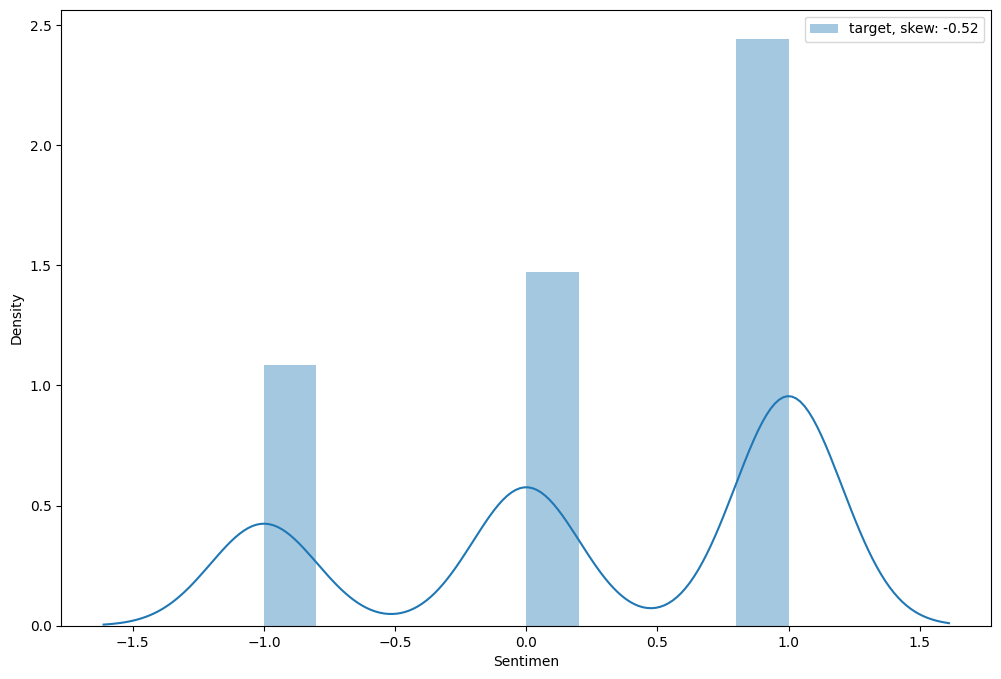

In [58]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [59]:
dataset_label.value_counts()

,count
Sentimen,
1.0,441
0.0,266
-1.0,196


# Ekstraksi Fitur dan Machine Learning

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [61]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [62]:
test_x

,ProcessedText
70,tips ilmuwan tingkat kebal tubuh mari lawan co...
457,cegah covid number serta jajar polsek ranji ak...
218,warga kabupaten lampung utara nyata positif pa...
250,mimpi malam allcaps psbb allcaps tahan batal c...
39,ayo elongated repeated putus mata rantai seman...
...,...
864,orang bahaya covid number lurus belok pergi
638,halo gerak lawan covid number ayo juang inform...
352,personil polsek karanglewas laksana patroli ma...
465,amal langkah langkah cegah tular allcaps covid...


## load TF-IDF

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

## Naive Bayes

In [65]:
from sklearn.naive_bayes import MultinomialNB

In [66]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [67]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [68]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [69]:
classifier_nb.fit(train_x, train_label.ravel())

<ipython-input-69-4a4839e58558>:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  classifier_nb.fit(train_x, train_label.ravel())


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [70]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.9762658227848101
Accuracy Test set:  0.5904059040590406


In [71]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.9762658227848101
Recall Test set:  0.5904059040590406


In [72]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.9763676139089341
Precision Test set:  0.569541371806291


In [73]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9762757318902684
F1 Test set:  0.5723164269765865


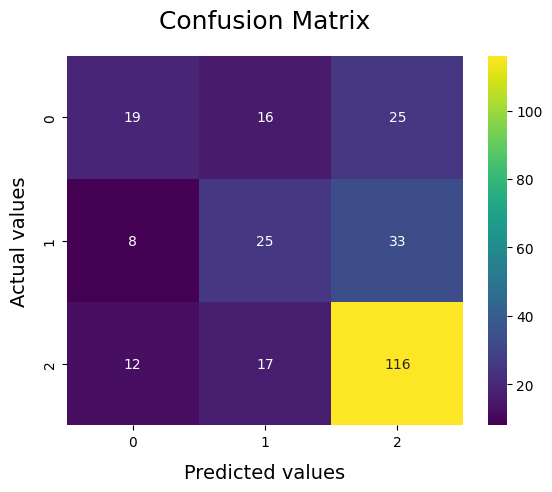

In [74]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [75]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))])

In [76]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 1)


# Visualisasi

In [77]:
models = [
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [78]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.976266,0.590406


In [79]:
models_comparison = [
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)
                    ]

In [80]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.590406,0.590406,0.569541,0.572316


<ipython-input-81-2f10045df05b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
<ipython-input-81-2f10045df05b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])


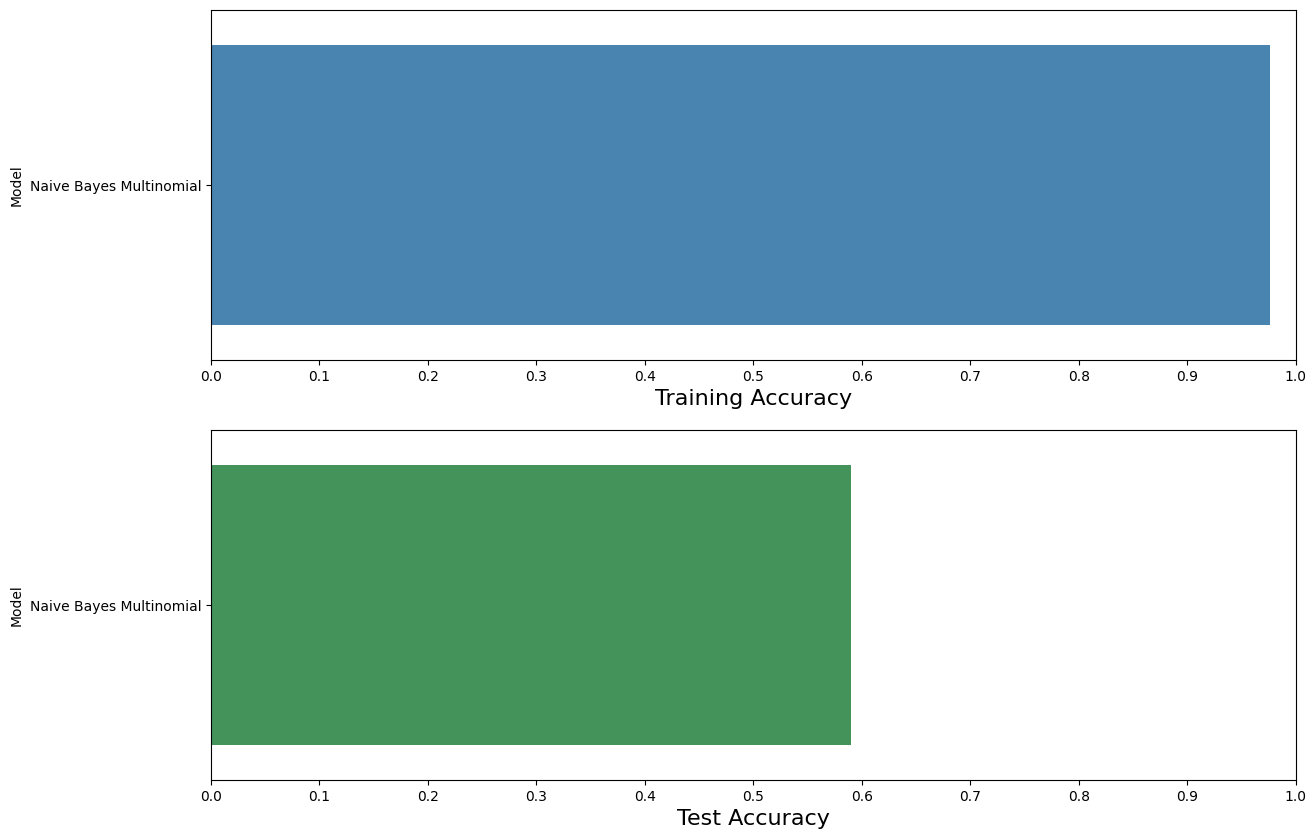

In [81]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

# simpan kedalam joblib

In [82]:
import joblib

In [83]:
# save the model to disk
joblib.dump(classifier_nb.best_estimator_, 'classifier_nb.best_estimator_.sav', compress=1)

['classifier_nb.best_estimator_.sav']